# **LOADING DATA**

In [ ]:
# DRIVE --> LOCALLY ON COLAB

from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/HAM.zip'
local_dir = '/tmp/HAM'  # Load Files Locally for Faster Uploading

if not os.path.exists(zip_path):
    print(f"ZIP file not found at {zip_path}. Please check the path.")
else:
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(local_dir)
        print(f"Files successfully extracted to {local_dir}.")
    except zipfile.BadZipFile:
        print("The ZIP file is corrupted or invalid.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files successfully extracted to /tmp/HAM.


# **IMPORTING LIBRARIES**

In [ ]:
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tqdm.notebook import tqdm
import cv2
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

# **TRANSFORMERS**

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random cropping
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontally
    transforms.RandomRotation(15),  # Rotate by 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Slight translations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# **OVERSAMPLING THE MALIGNANT CLASS**

In [ ]:
mild_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
])

# Define dataset paths
base_path = "/tmp/HAM/HAM/DatasetHAM"
sets = ["train", "val", "test"]

for dataset in sets:
    benign_path = os.path.join(base_path, dataset, "benign")
    malignant_path = os.path.join(base_path, dataset, "malignant")

    if not os.path.exists(benign_path) or not os.path.exists(malignant_path):
        print(f"Skipping {dataset} - missing directories")
        continue

    # Count images
    benign_count = len(os.listdir(benign_path))
    malignant_count = len(os.listdir(malignant_path))

    # Calculate needed images
    if malignant_count >= benign_count:
        print(f"{dataset} is balanced ({malignant_count} malignant, {benign_count} benign).")
        continue

    images_needed = benign_count - malignant_count
    existing_images = os.listdir(malignant_path)

    print(f"Generating {images_needed} images for {dataset}/malignant...")

    generated_count = 0
    while generated_count < images_needed:
        img_name = random.choice(existing_images)
        img_path = os.path.join(malignant_path, img_name)

        original_img = Image.open(img_path).convert("RGB")
        augmented_img = mild_augmentation(original_img)  # Apply only mild augmentations

        save_path = os.path.join(malignant_path, f"aug_{generated_count + 1}.jpg")
        augmented_img.save(save_path)

        generated_count += 1

    print(f"Completed augmentation for {dataset}/malignant. Total: {malignant_count + images_needed}")


Generating 3969 images for train/malignant...
Completed augmentation for train/malignant. Total: 5239
Generating 916 images for val/malignant...
Completed augmentation for val/malignant. Total: 1209
Generating 1222 images for test/malignant...
Completed augmentation for test/malignant. Total: 1613


# **DATASETS + DATALOADERS**

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root='/tmp/HAM/HAM/DatasetHAM/train', transform=train_transform)
val_dataset = ImageFolder(root='/tmp/HAM/HAM/DatasetHAM/val', transform=test_val_transform)
test_dataset = ImageFolder(root='/tmp/HAM/HAM/DatasetHAM/test', transform=test_val_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
from collections import Counter

def count_images_in_folders(base_dir):
    class_counts = {}
    for class_name in os.listdir(base_dir):  # Iterate over 'benign' and 'malignant'
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images in each dataset
train_counts = count_images_in_folders('/tmp/HAM/HAM/DatasetHAM/train')
val_counts = count_images_in_folders('/tmp/HAM/HAM/DatasetHAM/val')
test_counts = count_images_in_folders('/tmp/HAM/HAM/DatasetHAM/test')

print("Class distribution in datasets:")
print("Train:", train_counts)
print("Validation:", val_counts)
print("Test:", test_counts)

Class distribution in datasets:
Train: {'malignant': 5239, 'benign': 5239}
Validation: {'malignant': 1209, 'benign': 1209}
Test: {'malignant': 1613, 'benign': 1613}


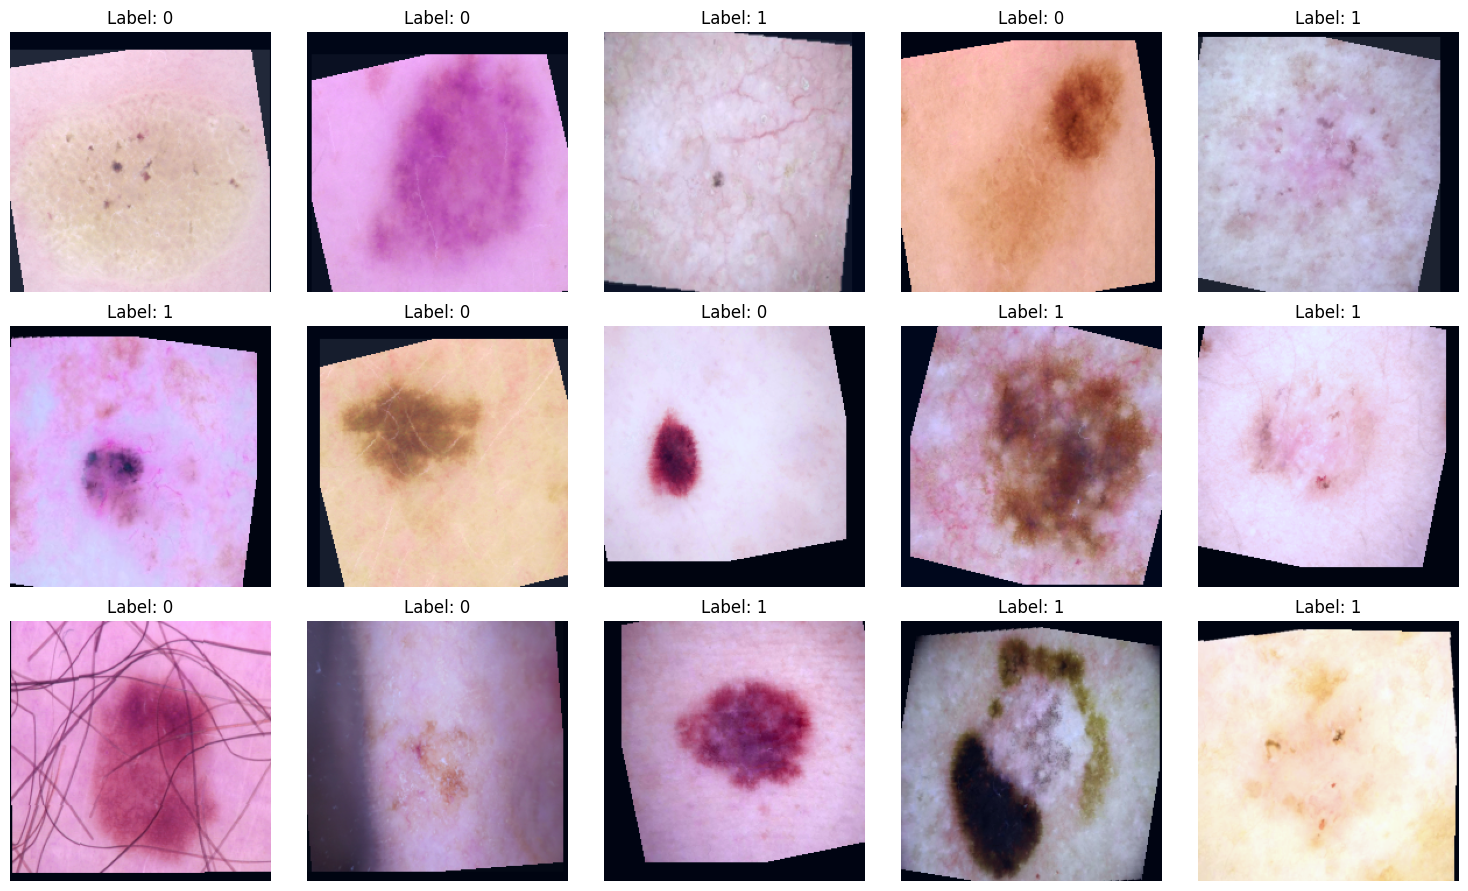

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

# Get a batch from the dataloader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the first 15 images from the batch
for i in range(min(15, len(images))):
    img = images[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display

    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# **MODEL ARCHITECTURE**

In [ ]:
class NeuralNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 12, 3)
        self.conv2 = nn.Conv2d(12, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64*26*26, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# **LOAD OWN MODEL vs RESNET18 MODEL**

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze early layers (conv1, layer1, layer2)
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.layer1.parameters():
    param.requires_grad = False
for param in model.layer2.parameters():
    param.requires_grad = False

# Modify the fully connected layer for 2 classes
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # 50% dropout
    nn.Linear(num_features, 2)
)

# Move model to GPU (Tesla T4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("✅ Model loaded and early layers frozen.")


✅ Model loaded and early layers frozen.


In [ ]:
model = NeuralNet()

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

22067330

# **DEFINE LOSS FUNCTION AND OPTIMIZER**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-4)  # Added weight decay for regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)  # Added scheduler

# **TRAINING AND VALIDATION LOOP**

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    best_val_acc = 0.0  # Track best accuracy
    patience = 3  # Early stopping patience
    epochs_no_improve = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training Phase
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Added gradient clipping
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []  # For precision, recall, F1
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = 100 * correct / total
        val_loss_avg = val_loss / len(val_loader)
        print(f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%")

        # Enhanced Metrics
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
        print(f"Val Precision: {precision:.4f}, Val Recall: {recall:.4f}, Val F1: {f1:.4f}")

        # Learning Rate Scheduling
        scheduler.step(val_loss_avg)  # Adjust LR based on validation loss

        # Save best model and early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_resnet50_frozen.pth")
            print("✅ Model saved!")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement in {epochs_no_improve}/{patience} epochs.")
            if epochs_no_improve >= patience:
                print("Early stopping triggered!")
                break

    print(f"🎯 Best Validation Accuracy: {best_val_acc:.2f}%")
    return best_val_acc

# **TESTING LOOP**

In [ ]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    test_loss_avg = test_loss / len(test_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    print(f"Test Loss: {test_loss_avg:.4f}, Test Acc: {test_acc:.2f}%")
    print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}")
    return test_acc

In [ ]:
num_epochs = 30
best_val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

# Load best model and evaluate on test set
model.load_state_dict(torch.load("best_resnet50_frozen.pth"))
print("\nEvaluating best model on test set:")
test_acc = test_model(model, test_loader, criterion)

# **VISUALIZE THE DECISION MAKING OF THE MODEL**

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.feature_maps = None

        # Register hooks
        target_layer.register_forward_hook(self.save_features)
        target_layer.register_backward_hook(self.save_gradients)

    def save_features(self, module, input, output):
        self.feature_maps = output  # Save forward pass feature maps

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Save backward pass gradients

    def generate_heatmap(self, class_idx):
        # Global Average Pooling of Gradients
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        # Weight feature maps by corresponding gradients
        cam = torch.zeros_like(self.feature_maps[0][0])
        for i in range(self.feature_maps.shape[1]):
            cam += pooled_gradients[i] * self.feature_maps[0, i, :, :]

        # Normalize heatmap
        cam = torch.clamp(cam, min=0)  # ReLU
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam.cpu().detach().numpy()

def apply_heatmap_on_image(image, heatmap):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize to match image size
    heatmap = np.uint8(255 * heatmap)  # Convert to 0-255 range
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap
    overlay = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)  # Overlay heatmap
    return overlay

# Select target layer (Last conv layer of ResNet-50)
target_layer = model.layer4

# Create Grad-CAM instance
grad_cam = GradCAM(model, target_layer)

# Function to visualize Grad-CAM
def visualize_gradcam(image_tensor, class_idx):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension

    # Forward pass
    output = model(image_tensor)
    model.zero_grad()

    # Backward pass for specific class
    class_score = output[0, class_idx]  # Target class score
    class_score.backward()

    # Generate heatmap
    heatmap = grad_cam.generate_heatmap(class_idx)

    # Convert tensor image to numpy
    image = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0,1]
    image = (image * 255).astype(np.uint8)  # Convert to uint8 for OpenCV

    # Ensure original image stays unchanged
    original_image = image.copy()

    # Apply heatmap
    cam_result = apply_heatmap_on_image(image, heatmap)

    # Show results
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Grad-CAM Heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(cam_result)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.show()

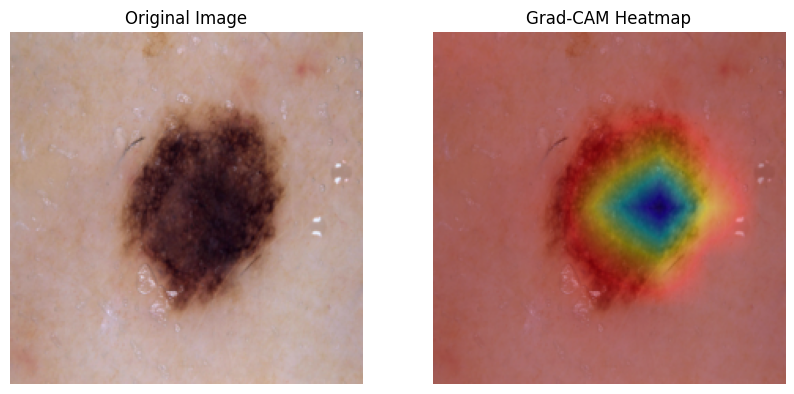

In [ ]:
image_path = "/content/ISIC_0024319.jpg"
image = Image.open(image_path)

# Preprocessing (match model's training setup)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_tensor = transform(image)

# Get model prediction
model.eval()
output = model(image_tensor.unsqueeze(0).to(device))
predicted_class = torch.argmax(output).item()

# Visualize Grad-CAM for predicted class
visualize_gradcam(image_tensor, predicted_class)